In [1]:
from os import environ
environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
from __future__ import print_function
import json
from pprint import pprint
import numpy as np

import keras
from functools import reduce
import re
from nltk.tokenize import word_tokenize
from keras import optimizers
from keras.utils.data_utils import get_file
from keras.layers.embeddings import Embedding
from keras import layers
from keras.layers import Activation,recurrent, Bidirectional, Dense, Flatten, Conv1D, Dropout, LSTM, GRU, concatenate, multiply, add, Reshape, MaxPooling1D, BatchNormalization
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K

Using TensorFlow backend.


In [3]:
def get_dictionary(vocab):
    d = dict()
    with open(vocab) as f:
        lines = f.readlines()
        for l in lines:
            values = l.strip().split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            d[word] = coefs
    return d

In [4]:
d = get_dictionary("glove/glove.6B.300d.txt")

In [5]:
with open('train.json') as data_file:    
    data = json.load(data_file)

In [6]:
ids = []
titles = dict()
contexts = dict()
questions = dict()
answers_text = dict()
answers_start = dict()
for i in range(len(data)):
    paragraphs = data[i]["paragraphs"]
    title = data[i]["title"]
    for j in range(len(paragraphs)):
        context = paragraphs[j]["context"]
        qas = paragraphs[j]["qas"]
        for k in range(len(qas)):
            id_ = qas[k]["id"]
            answer = qas[k]["answer"]
            question = qas[k]["question"]
            ids.append(id_)
            titles[id_] = title
            contexts[id_] = context
            answers_start[id_] = answer["answer_start"]
            answers_text[id_] = answer["text"]
            questions[id_] = question


In [7]:
max_para = 650
max_q = 50
dimension = 300
train_len = 500#len(ids)

In [8]:
paras = np.zeros((train_len, max_para, dimension))
qns = np.zeros((train_len, max_q, dimension))

In [9]:
for i in range(train_len):
    if i % 1000 == 0:
        print(i)
    words = word_tokenize(contexts[ids[i]].lower())
    qs = word_tokenize(questions[ids[i]].lower())
    for j in range(min(max_para - 1, len(words))):
        if words[j] in d:
            paras[i][j] = d[words[j]]
    for j in range(min(max_q - 1, len(qs))):
        if qs[j] in d:
            qns[i][j] = d[qs[j]]

0


In [10]:
def create_one_hot_answer(para, answer, answer_start, option, max_length):
    if option == "s":
        from_begin = para[0:answer_start]
    else:
        from_begin = para[0:answer_start+len(answer)]
    l = len(word_tokenize(from_begin))
    one_hot = np.zeros(max_length)
    if option == "s":
        one_hot[min(max_para-1,l)] = 1
    else:
        one_hot[min(max_para-1,l-1)] = 1
    return one_hot
    

In [11]:
ans_starts = [create_one_hot_answer(contexts[ids[i]], answers_text[ids[i]], answers_start[ids[i]], "s", max_para) for i in range(train_len)]

In [12]:
ans_ends = [create_one_hot_answer(contexts[ids[i]], answers_text[ids[i]], answers_start[ids[i]], "e", max_para) for i in range(train_len)]

In [13]:

def LSTM_D(hidden_unit, input_layer, h_state, c_state, Wi, Wf, Wc, Wo):

    i = concatenate([input_layer, h_state])
    i = Wi(i)
    i = Activation('sigmoid')(i)

    ft = Wf(i)
    ft = Activation('sigmoid')(i)

#     it = Dense(hidden_unit)(i)
#     it = Activation('sigmoid')(i)

    Ct_ = Wc(i)
    Ct_ = Activation('tanh')(i)

    Ct1 = multiply([ft, c_state])
    Ct2 = multiply([i, Ct_])
    Ct = add([Ct1, Ct2])

    ot = Wo(i)

    ht = multiply([ot, Ct])

    return ht, Ct

def HMN(U, h, us, ue):
    r = concatenate([h, us, ue])
    r = Dense(dimension)(r)
    r = Activation('tanh')(r)
    
    mt1 = concatenate([U, r], axis = 2)
    mt1 = Dense()

In [14]:
#Convoluion, batch norm, relu unit
def convBN_pool(input_layer, conv_channels):
    convlayer = Conv1D(conv_channels, 3, padding = 'valid', strides = 2)(input_layer)
    BN = BatchNormalization(axis=-1, momentum = 0.99, epsilon=0.001, center=True, scale = True, 
                            beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros')(convlayer)
    activation = layers.PReLU()(BN)

    return activation

def convBN(input_layer, conv_channels):
    convlayer = Conv1D(conv_channels, 5, padding = 'same')(input_layer)
    BN = BatchNormalization(axis=-1, momentum = 0.99, epsilon=0.001, center=True, scale = True, 
                            beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', 
                            beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)(convlayer)
    activation = layers.PReLU()(BN)

    return activation

def RU(input_layer, conv_channels, d_rate):
    # input tensor for a 3-channel 256x256 image
    x = input_layer
    # 3x3 conv with 3 output channels (same as input channels)
    y = Conv1D(conv_channels, 3, padding='same', dilation_rate = d_rate)(x)
    y = Conv1D(conv_channels, 3, padding='same', dilation_rate = d_rate)(y)
    # this returns x + y.
    z = layers.add([x, y])
    z = layers.PReLU()(z)
    return z

In [49]:

RNN = recurrent.LSTM
EMBED_HIDDEN_SIZE = 300
BATCH_SIZE = 128
EPOCHS = 2
hidden_unit = 200
#shared weight layers
shared_LSTM = LSTM(EMBED_HIDDEN_SIZE, return_sequences=True)
shared_start = Dense(max_para, activation='softmax')
shared_end = Dense(max_para, activation='softmax')
Wi = Dense(hidden_unit)
Wf = Dense(hidden_unit)
Wc = Dense(hidden_unit)
Wo = Dense(hidden_unit)
###########################
sentence = layers.Input(shape=(max_para,dimension), dtype='float32')
encoded_sentence =shared_LSTM(sentence)

question = layers.Input(shape=(max_q,dimension), dtype='float32')
encoded_question = shared_LSTM(question)

merge_1 = layers.dot([encoded_sentence, encoded_question], axes = 2 )
A_Q = layers.Activation("softmax")(merge_1)
merge_2 = layers.dot([encoded_question, encoded_sentence], axes = 2 )
A_D = layers.Activation("softmax")(merge_2)
C_Q = layers.dot([A_Q, encoded_sentence], axes = 1 )

C_Q = layers.concatenate([encoded_question, C_Q], axis=2)
C_D = layers.dot([A_D, C_Q], axes=1)
C_ = layers.concatenate([encoded_sentence, C_D], axis=2)

U = Bidirectional(LSTM(EMBED_HIDDEN_SIZE, return_sequences=True))(C_)
U = Dropout(0.5)(U)

start = convBN(U, 200)
print(start.shape)
start = RU(start, 200, 1)
start = Dropout(0.5)(start)
start = convBN_pool(start, 100)
start = RU(start, 100, 1)
start = RU(start, 100, 1)
start = RU(start, 100, 1)
start = convBN_pool(start, 100)
start = RU(start, 100, 2)
start = Dropout(0.5)(start)
start = convBN_pool(start, 128)
start = RU(start, 128, 1)
start = RU(start, 128, 1)
start = RU(start, 128, 2)
start = Dropout(0.5)(start)
start = convBN_pool(start, 256)
start = RU(start, 256, 2)
start = Dropout(0.5)(start)
start = convBN_pool(start, 128)
start = RU(start, 128, 1)
start = RU(start, 128, 1)
print(start.shape)
start = Reshape((19*128,))(start)
print(start.shape)
out = Dropout(0.5)(start)
h_state_i = layers.Input(shape=(hidden_unit,))
h_state = Dense(hidden_unit, kernel_initializer = keras.initializers.Zeros())(h_state_i)

C_state_i = layers.Input(shape=(hidden_unit,))
C_state = Dense(hidden_unit, kernel_initializer = keras.initializers.Zeros())(C_state_i)

out_concat = concatenate([out, h_state])
start_init = shared_start(out_concat)
end_init = shared_end(out_concat)




#########################
for i in range(5):
    start_comb = Reshape((max_para,1))(start_init)
    end_comb = Reshape((max_para,1))(end_init)
    combine_output = concatenate([start_comb,end_comb], axis = 2)
    LSTM_input = layers.dot([combine_output, U], axes = 1)
    LSTM_input = Reshape((2*600,))(LSTM_input)

    h_state, C_state = LSTM_D(hidden_unit, LSTM_input, h_state, C_state, Wi, Wf, Wc, Wo)

    print(out.shape)
    print(h_state.shape)
    out_concat = concatenate([out, h_state])
    start = shared_start(out_concat)
    end = shared_end(out_concat)

# print(combine_output.shape)
# decoder = Model(input_D, [start, end])

# encode = encoder([sentence, question])
# print(encode.shape)
# decode = decoder(encode)
# combine = Model([sentence, question], decode)

(?, 650, 200)
(?, 19, 128)
(?, 2432)
(?, 2432)
(?, 200)
(?, 2432)
(?, 200)
(?, 2432)
(?, 200)
(?, 2432)
(?, 200)
(?, 2432)
(?, 200)


In [50]:
model = Model([sentence, question, h_state_i, C_state_i],[start, end])

In [51]:
optimizer = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [52]:
ans_s = np.array(ans_starts)
ans_e = np.array(ans_ends)

In [53]:
print('Training')
h =np.zeros((train_len,hidden_unit,))
c = np.zeros((train_len, hidden_unit))
for i in range(1):
    model.fit([paras, qns, h, c], [ans_s, ans_e],
              batch_size=80, epochs=50)
#     model.save('coa_resnet2_new.h5')

Training
Epoch 1/50
500/500 [==============================] - 35s - loss: 12.6302 - dense_57_loss: 6.3388 - dense_58_loss: 6.2914 - dense_57_acc: 0.0180 - dense_58_acc: 0.0060      
Epoch 2/50
500/500 [==============================] - 26s - loss: 10.1944 - dense_57_loss: 5.0705 - dense_58_loss: 5.1239 - dense_57_acc: 0.0320 - dense_58_acc: 0.0100    
Epoch 3/50
500/500 [==============================] - 26s - loss: 9.8608 - dense_57_loss: 4.8933 - dense_58_loss: 4.9675 - dense_57_acc: 0.0200 - dense_58_acc: 0.0160    
Epoch 4/50
500/500 [==============================] - 26s - loss: 9.6471 - dense_57_loss: 4.7837 - dense_58_loss: 4.8634 - dense_57_acc: 0.0320 - dense_58_acc: 0.0140      
Epoch 5/50
500/500 [==============================] - 28s - loss: 9.5055 - dense_57_loss: 4.7173 - dense_58_loss: 4.7882 - dense_57_acc: 0.0360 - dense_58_acc: 0.0200    
Epoch 6/50
500/500 [==============================] - 26s - loss: 9.3179 - dense_57_loss: 4.6452 - dense_58_loss: 4.6727 - dense_5

500/500 [==============================] - 26s - loss: 2.0588 - dense_57_loss: 1.0389 - dense_58_loss: 1.0199 - dense_57_acc: 0.6660 - dense_58_acc: 0.6440    
Epoch 49/50
500/500 [==============================] - 26s - loss: 2.2336 - dense_57_loss: 1.1561 - dense_58_loss: 1.0775 - dense_57_acc: 0.6440 - dense_58_acc: 0.6560    
Epoch 50/50
500/500 [==============================] - 25s - loss: 1.9313 - dense_57_loss: 1.0076 - dense_58_loss: 0.9237 - dense_57_acc: 0.6560 - dense_58_acc: 0.6820    


In [39]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_25 (InputLayer)            (None, 650, 300)      0                                            
____________________________________________________________________________________________________
input_26 (InputLayer)            (None, 50, 300)       0                                            
____________________________________________________________________________________________________
lstm_13 (LSTM)                   multiple              721200                                       
____________________________________________________________________________________________________
dot_36 (Dot)                     (None, 650, 50)       0                                            
___________________________________________________________________________________________

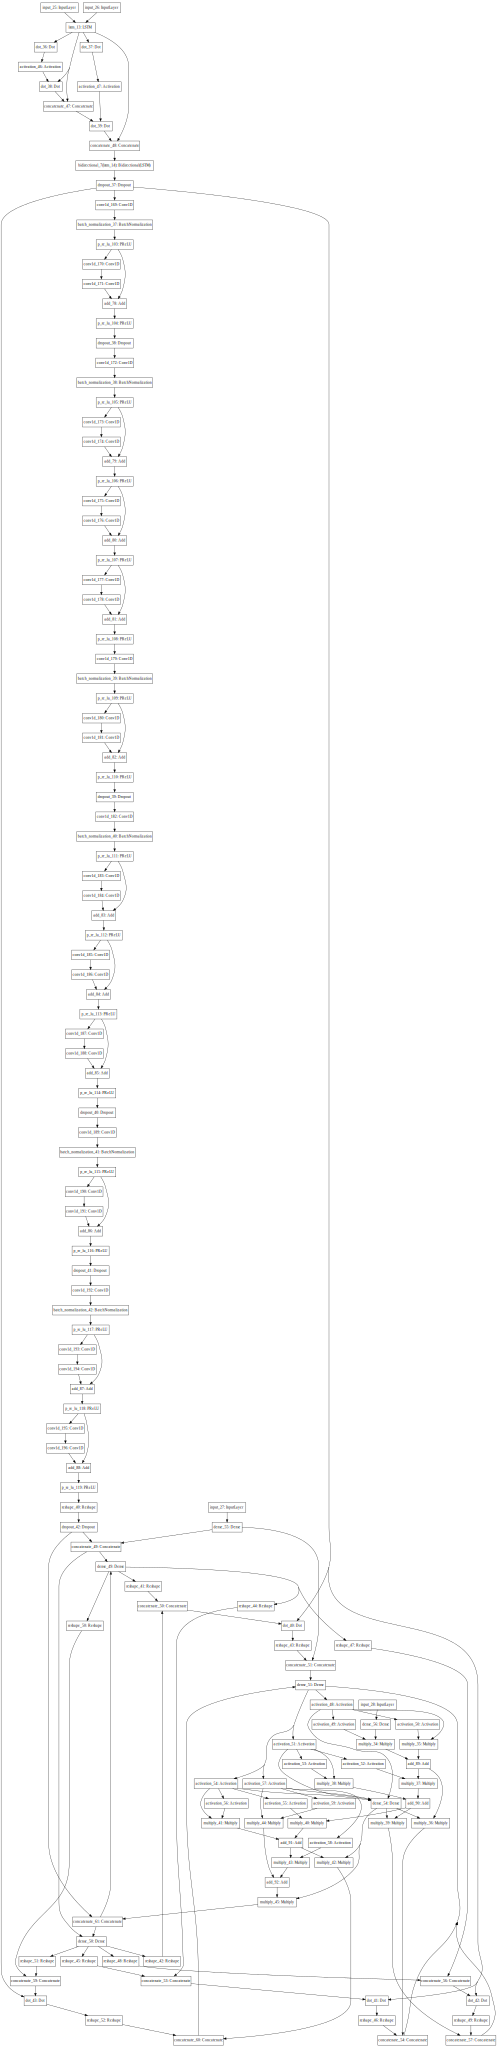

In [40]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [41]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [54]:
print('Training')
h =np.zeros((train_len,hidden_unit,))
c = np.zeros((train_len, hidden_unit))
for i in range(1):
    model.fit([paras, qns, h, c], [ans_s, ans_e],
              batch_size=80, epochs=50)
#     model.save('coa_resnet2_new.h5')

Training
Epoch 1/50
500/500 [==============================] - 26s - loss: 1.7808 - dense_57_loss: 0.8655 - dense_58_loss: 0.9152 - dense_57_acc: 0.7140 - dense_58_acc: 0.7100    
Epoch 2/50
500/500 [==============================] - 27s - loss: 1.5033 - dense_57_loss: 0.7891 - dense_58_loss: 0.7142 - dense_57_acc: 0.7500 - dense_58_acc: 0.7820    
Epoch 3/50
500/500 [==============================] - 26s - loss: 1.5711 - dense_57_loss: 0.7757 - dense_58_loss: 0.7954 - dense_57_acc: 0.7540 - dense_58_acc: 0.7460    
Epoch 4/50
500/500 [==============================] - 26s - loss: 1.4325 - dense_57_loss: 0.7262 - dense_58_loss: 0.7063 - dense_57_acc: 0.7660 - dense_58_acc: 0.7580    
Epoch 5/50
500/500 [==============================] - 27s - loss: 1.5241 - dense_57_loss: 0.7709 - dense_58_loss: 0.7532 - dense_57_acc: 0.7460 - dense_58_acc: 0.7520    
Epoch 6/50
500/500 [==============================] - 26s - loss: 1.4422 - dense_57_loss: 0.6912 - dense_58_loss: 0.7510 - dense_57_acc:

500/500 [==============================] - 26s - loss: 0.4088 - dense_57_loss: 0.2044 - dense_58_loss: 0.2044 - dense_57_acc: 0.9500 - dense_58_acc: 0.9420    
Epoch 49/50
500/500 [==============================] - 25s - loss: 0.2952 - dense_57_loss: 0.1554 - dense_58_loss: 0.1398 - dense_57_acc: 0.9640 - dense_58_acc: 0.9720    
Epoch 50/50
500/500 [==============================] - 27s - loss: 0.2178 - dense_57_loss: 0.0969 - dense_58_loss: 0.1209 - dense_57_acc: 0.9760 - dense_58_acc: 0.9620    
